In [1]:
from scipy.stats import poisson
import pandas as pd
import numpy as np
import pickle
from classes import NN
import torch
from functions import significance
import matplotlib.pyplot as plt

def cls(nobs, sigmax, clevel):
    # nobs = number of observed events, nobs = nbak for expected limits
    # sigmax = range of signal you want to scan
    # clevel = confidence level
    nbak = nobs # number of observed events
    found = False
    for nsig in  range(0,sigmax):
        CLsb = 0
        CLb = 0
        if not found:
            for n in range(0,nobs+1):
                p1 = poisson.pmf(k=n, mu=nsig+nbak)
                p2 = poisson.pmf(k=n, mu=nbak)
                # print(n,", ",p1,", ",p2)
                CLsb = CLsb+p1
                CLb = CLb+p2
            CLs = CLsb/CLb
#             print("sig = ", nsig,": CLsb: ", CLsb,", CLb: ", CLb, " -->  CLs: ", CLs)
            if (CLs<clevel):
                found = True
                print("==> Signal upper limit = ", nsig-1)
                return nsig-1
    print('Not found ==> 0')
    return 0

                
def run_model(data):
    input_size = 20
    activation_function = 'relu'
    output_size = 1
    hidden_size = 50
    hidden_layers = 2
    model_path = '..//output_temp/report_output/best_state_0.01.pth'
    model = NN(input_size, hidden_size, hidden_layers, activation_function, output_size)
    model.load_state_dict(torch.load(model_path))

    model.eval()
    with torch.no_grad():
        batch = data[0]
        labels = data[1]
        weights = data[2]

        prob_weights_labels = np.zeros((len(batch), 3))

        out = model(batch)
        prob_weights_labels[:, 0] = out[:, 0]
        prob_weights_labels[:, 1] = weights
        prob_weights_labels[:, 2] = labels

        s, b, _ = significance(prob_weights_labels, bins=20)
    return s, b

def optimiseCLs(b_tot, s_tot, label):
    xs = np.inf
    for region in range(18): 
        s_region_b = b_tot[2 + region:]
        s_region_s = s_tot[2 + region:]
        nobs = int(np.ceil(s_region_b.sum()))
        print('nobs = ', nobs)
        nsel = int(np.ceil(s_region_s.sum()))
        sigmax = 10*nobs 
        clevel = 0.05
        bins = np.arange(0.1, 1.0, 0.05)

        ul = cls(nobs, sigmax, clevel)
        if ul == 0:
            break
        if nsel == 0:
            continue
            
        xs_temp = 0.05 * (ul/nsel) * 1/0.1008
        if xs_temp < xs:
            xs = xs_temp
            cut = bins[region]
#     if xs == np.inf:
#         print('Upper limit not found')
#         return 
#     else:
    print('------------------------------------')
    print(f'{label} cross section = {xs} pb \n')
    print(f'{label} optimal cut = {cut}')
    print('------------------------------------\n')
    return xs, cut

In [13]:
 # loading raw data and applying b-tag selection for calculating normalisation factors
def pre_selection(df):
    dfout = df.loc[(df["region"] == 1) | (df["region"] == 2)]
    dfout = dfout.loc[dfout["regime"] == 1]
    dfout = dfout.loc[(dfout["nTags"] == 2)]
    dfout.drop(columns=["nTags", "MCChannelNumber", "region", "regime", "dEtaBB", "dPhiBB"], inplace=True)
    return dfout

path = '..//Raw Data/background.csv'
bkg = pd.read_csv(path, index_col=0)
bkg = pre_selection(bkg)

norms = []
signal_mass = [300, 420, 440, 460, 500, 600, 700, 800, 900, 1000, 1400, 1600, 2000, 1200]
for mass in signal_mass:
    df = pd.read_csv(f'..//Raw Data/{mass}.csv', index_col=0)
    df = pre_selection(df)
    norms.append(df.weight.sum())

# loading data for the PNN
data_dict = '..//output_temp/report_output/data_dict_0.01.pkl'
with open(data_dict, 'rb') as f:
    data = pickle.load(f)

C:\Users\Ross\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


nobs =  15
==> Signal upper limit =  9
nobs =  6
==> Signal upper limit =  6
nobs =  4
==> Signal upper limit =  5
nobs =  2
==> Signal upper limit =  4
nobs =  2
==> Signal upper limit =  4
nobs =  1
==> Signal upper limit =  4
nobs =  1
==> Signal upper limit =  4
nobs =  1
==> Signal upper limit =  4
nobs =  1
==> Signal upper limit =  4
nobs =  1
==> Signal upper limit =  4
nobs =  1
==> Signal upper limit =  4
nobs =  1
==> Signal upper limit =  4
nobs =  1
==> Signal upper limit =  4
nobs =  1
==> Signal upper limit =  4
nobs =  1
==> Signal upper limit =  4
nobs =  1
==> Signal upper limit =  4
nobs =  1
==> Signal upper limit =  4
nobs =  0
Not found ==> 0
------------------------------------
300 cross section = 0.27901785714285715 pb 

300 optimal cut = 0.1
------------------------------------

nobs =  19
==> Signal upper limit =  10
nobs =  8
==> Signal upper limit =  7
nobs =  5
==> Signal upper limit =  6
nobs =  3
==> Signal upper limit =  5
nobs =  2
==> Signal upper limi

nobs =  316
==> Signal upper limit =  36
nobs =  220
==> Signal upper limit =  30
nobs =  157
==> Signal upper limit =  26
nobs =  112
==> Signal upper limit =  22
nobs =  80
==> Signal upper limit =  19
nobs =  55
==> Signal upper limit =  16
nobs =  39
==> Signal upper limit =  14
nobs =  27
==> Signal upper limit =  12
nobs =  16
==> Signal upper limit =  9
nobs =  10
==> Signal upper limit =  8
nobs =  5
==> Signal upper limit =  6
nobs =  3
==> Signal upper limit =  5
nobs =  1
==> Signal upper limit =  4
nobs =  1
==> Signal upper limit =  4
nobs =  1
==> Signal upper limit =  4
nobs =  1
==> Signal upper limit =  4
nobs =  1
==> Signal upper limit =  4
nobs =  1
==> Signal upper limit =  4
------------------------------------
460 cross section = 0.02994908655286014 pb 

460 optimal cut = 0.3500000000000001
------------------------------------

nobs =  379
==> Signal upper limit =  39
nobs =  264
==> Signal upper limit =  33
nobs =  189
==> Signal upper limit =  28
nobs =  135
==

==> Signal upper limit =  15
nobs =  40
==> Signal upper limit =  14
nobs =  34
==> Signal upper limit =  13
nobs =  27
==> Signal upper limit =  12
nobs =  22
==> Signal upper limit =  11
nobs =  14
==> Signal upper limit =  9
nobs =  7
==> Signal upper limit =  7
nobs =  2
==> Signal upper limit =  4
------------------------------------
700 cross section = 0.010227458681066929 pb 

700 optimal cut = 0.7500000000000002
------------------------------------

nobs =  156
==> Signal upper limit =  26
nobs =  138
==> Signal upper limit =  24
nobs =  125
==> Signal upper limit =  23
nobs =  113
==> Signal upper limit =  22
nobs =  103
==> Signal upper limit =  21
nobs =  95
==> Signal upper limit =  20
nobs =  88
==> Signal upper limit =  20
nobs =  80
==> Signal upper limit =  19
nobs =  72
==> Signal upper limit =  18
nobs =  63
==> Signal upper limit =  17
nobs =  56
==> Signal upper limit =  16
nobs =  48
==> Signal upper limit =  15
nobs =  41
==> Signal upper limit =  14
nobs =  33
==

nobs =  53
==> Signal upper limit =  16
nobs =  50
==> Signal upper limit =  15
nobs =  47
==> Signal upper limit =  15
nobs =  45
==> Signal upper limit =  14
nobs =  43
==> Signal upper limit =  14
nobs =  41
==> Signal upper limit =  14
nobs =  40
==> Signal upper limit =  14
nobs =  38
==> Signal upper limit =  13
nobs =  36
==> Signal upper limit =  13
nobs =  34
==> Signal upper limit =  13
nobs =  33
==> Signal upper limit =  13
nobs =  31
==> Signal upper limit =  12
nobs =  29
==> Signal upper limit =  12
nobs =  27
==> Signal upper limit =  12
nobs =  24
==> Signal upper limit =  11
nobs =  22
==> Signal upper limit =  11
nobs =  19
==> Signal upper limit =  10
nobs =  10
==> Signal upper limit =  8
------------------------------------
1000 cross section = 0.005693334244266813 pb 

1000 optimal cut = 0.9500000000000003
------------------------------------

nobs =  6
==> Signal upper limit =  6
nobs =  6
==> Signal upper limit =  6
nobs =  6
==> Signal upper limit =  6
nobs = 

nobs =  20
==> Signal upper limit =  10
nobs =  19
==> Signal upper limit =  10
nobs =  19
==> Signal upper limit =  10
nobs =  18
==> Signal upper limit =  10
nobs =  17
==> Signal upper limit =  9
nobs =  16
==> Signal upper limit =  9
nobs =  16
==> Signal upper limit =  9
nobs =  15
==> Signal upper limit =  9
nobs =  15
==> Signal upper limit =  9
nobs =  14
==> Signal upper limit =  9
nobs =  14
==> Signal upper limit =  9
nobs =  13
==> Signal upper limit =  8
nobs =  13
==> Signal upper limit =  8
nobs =  12
==> Signal upper limit =  8
nobs =  11
==> Signal upper limit =  8
nobs =  11
==> Signal upper limit =  8
nobs =  10
==> Signal upper limit =  8
nobs =  8
==> Signal upper limit =  7
------------------------------------
1200 cross section = 0.004532927183057731 pb 

1200 optimal cut = 0.9500000000000003
------------------------------------

nobs =  20
==> Signal upper limit =  10
nobs =  19
==> Signal upper limit =  10
nobs =  19
==> Signal upper limit =  10
nobs =  18
==> 

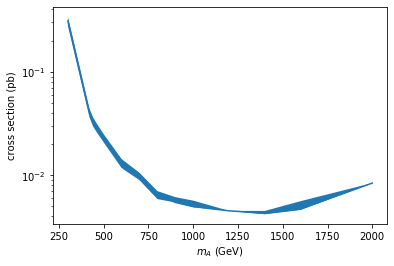

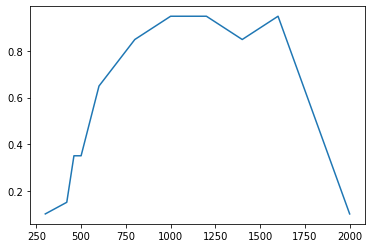

In [52]:
keys = list(data.keys())
vset = {key: data[key] for key in keys[3:16]} # validation set
tset = {key: data[key] for key in keys[16:]} # test set
bset = data['blind']

xs_95 = []
xs_95_lower = []
xs_95_upper = []
cuts = []
cuts_lower = []
cuts_upper = []

for (vkey, vvalue), (tkey, tvalue), norm in zip(vset.items(), tset.items(), norms):
    temp_xs = []
    temp_cuts = []
    for fluctuation in [0.8, 1.0, 1.2]:
        vs, vb = run_model(vvalue)
        ts, tb = run_model(tvalue)
        b_tot = np.array(vb) + np.array(tb)
        b_tot *= bkg.weight.sum() / b_tot.sum()
        s_tot = np.array(vs) + np.array(ts)
        s_tot *= norm / s_tot.sum()
        
        b_tot *= fluctuation
        xs, cut = optimiseCLs(b_tot, s_tot, label=vkey.split('_')[1])
        temp_xs.append(xs)
        temp_cuts.append(cut)
        
    xs_95_lower.append(temp_xs[0])  
    xs_95.append(temp_xs[1])
    xs_95_upper.append(temp_xs[2])
    cuts_lower.append(temp_cuts[0])
    cuts.append(temp_cuts[1])
    cuts_upper.append(temp_cuts[2])
    
temp_xs = []
temp_cuts = []
for fluctuation in [0.8, 1.0, 1.2]:    
    bs, bb = run_model(bset)
    b_tot = np.array(bb)
    b_tot *= bkg.weight.sum() / b_tot.sum()
    s_tot *= norms[-1] / s_tot.sum()
    xs, cut = optimiseCLs(b_tot, s_tot, label='1200')
    temp_xs.append(xs)
    temp_cuts.append(cut)

xs_95_lower.append(temp_xs[0])
xs_95.append(temp_xs[1])
xs_95_upper.append(temp_xs[2])
cuts_lower.append(temp_cuts[0])
cuts.append(temp_cuts[1])
cuts_upper.append(temp_cuts[2])

xs_95 = xs_95[:10] + [xs_95[-1]] + xs_95[10:-1]
xs_95_lower = xs_95_lower[:10] + [xs_95_lower[-1]] + xs_95_lower[10:-1]
xs_95_upper = xs_95_upper[:10] + [xs_95_upper[-1]] + xs_95_upper[10:-1]
cuts = cuts[:10] + [cuts[-1]] + cuts[10:-1]
cuts_lower = cuts_lower[:10] + [cuts_lower[-1]] + cuts_lower[10:-1]
cuts_upper = cuts_upper[:10] + [cuts_upper[-1]] + cuts_upper[10: -1]

signal_mass = [300, 420, 440, 460, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 2000]
plt.plot(signal_mass, xs_95)
plt.fill_between(signal_mass, xs_95_lower, xs_95_upper)
plt.xlabel(r'$m_A$ (GeV)')
plt.ylabel('cross section (pb)')
plt.yscale('log')
plt.show()

plt.plot(signal_mass, cuts)
plt.show()

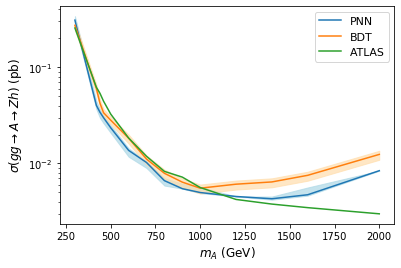

In [82]:
signal_mass = [300, 420, 440, 460, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 2000]
atlas = [0.2567278, 0.06197801, 0.05367791, 0.04442944, 0.03263386, 
        0.01840057, 0.01186416, 0.008270918, 0.00720765, 0.005616162,
         0.004222333, 0.003778599, 0.003469873, 0.002992314]
bdt = pd.read_csv('..//BDT_XS.csv')
pnn = pd.read_csv('..//xs_upperlimit.csv')

plt.plot(signal_mass, pnn['xs'], label='PNN')
plt.plot(signal_mass, bdt['xs'], label='BDT')
plt.plot(signal_mass, atlas, label='ATLAS')
plt.fill_between(signal_mass, pnn['xs_lower_uncertainty'], pnn['xs_upper_uncertainty'],
                 color='lightblue', alpha=0.7)
plt.fill_between(signal_mass, bdt['-20%'], bdt['20%'], color='navajowhite', alpha=0.7)
plt.xlabel(r'$m_A$ (GeV)', fontsize=12)
plt.ylabel(r'$\sigma(gg \rightarrow A \rightarrow Zh)$ (pb)', fontsize=12)
plt.yscale('log')
plt.legend(fontsize=11)
plt.savefig('PNN_ATLAS_XS.pdf')
plt.show()

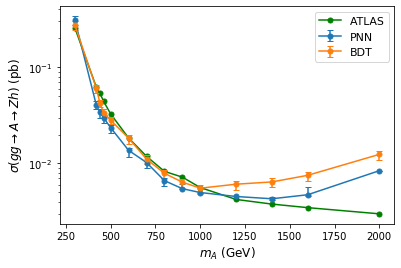

In [80]:
signal_mass = [300, 420, 440, 460, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 2000]
atlas = [0.2567278, 0.06197801, 0.05367791, 0.04442944, 0.03263386, 
        0.01840057, 0.01186416, 0.008270918, 0.00720765, 0.005616162,
         0.004222333, 0.003778599, 0.003469873, 0.002992314]
bdt = pd.read_csv('..//BDT_XS.csv')
pnn = pd.read_csv('..//xs_upperlimit.csv')

pnn_u = [pnn.iloc[:, 1] - pnn.iloc[:, 2], pnn.iloc[:, 3] - pnn.iloc[:, 1]]
bdt_u = [bdt.iloc[:, 1] - bdt.iloc[:, 3], bdt.iloc[:, 2] - bdt.iloc[:, 1]]

plt.plot(signal_mass, atlas,'-og', label='ATLAS', markersize=5)
plt.errorbar(signal_mass, pnn['xs'], yerr=pnn_u, fmt='-o', markersize=5, capsize=3, label='PNN')
plt.errorbar(signal_mass, bdt['xs'], yerr=bdt_u, fmt='-o', markersize=5, capsize=3, label='BDT')
plt.xlabel(r'$m_A$ (GeV)', fontsize=12)
plt.ylabel(r'$\sigma(gg \rightarrow A \rightarrow Zh)$ (pb)', fontsize=12)
plt.yscale('log')
plt.legend(fontsize=11)
plt.savefig('..//Report Plots/section5/PNN_XS.pdf')
plt.show()

In [101]:
improvement = list(100 * (np.array(atlas) - pnn.iloc[:, 1]) / np.array(atlas))[1: 10]
np.array(improvement).mean()

25.227391196888185